In [19]:
import numpy as np
import scipy as sc
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn import linear_model
import warnings
import statsmodels.formula.api as smf
import pylab
import statsmodels.api as sm

warnings.filterwarnings('ignore')

## 1-Import and clean the dataset

### Import the dataset

In [20]:
## Notice the root we have set; be sure to change to make the python work.
Stock=pd.read_csv('/Users/lihuayu/Documents/UMich-New Start/Extra Help/Christ/Christmas_proj/data2.csv')

### Separate the dataset into several pieces

In [21]:
StockA=Stock[Stock['symbol']=='STOCKA']
StockB=Stock[Stock['symbol']=='STOCKB']

In [22]:
## Note that the length of Stock_A dataset is 224802, and for Stock_B, that is 225632
Stock_A=StockA[StockA['bid']!=0]
Stock_B=StockB[StockB['bid']!=0]
trade_A=StockA[StockA['bid']==0]
trade_B=StockB[StockB['bid']==0]
#plt.plot((Stock_A['time']-min(Stock_A['time']))[0:100000],Stock_A['ask'][0:100000],'r--')

Here we will consider regression model to predict the stock price. Because the price may relate to  previous record, so here we will paste the former three records into the dataset.

In [23]:
### To begin with, we delete the duplicate records to compress the data
ST_A=Stock_A.drop_duplicates(['bid','bidsz','ask','asksz'],'first',inplace=False)
ST_A=ST_A[['time','bid','bidsz','ask','asksz']]
ST_A=ST_A.reset_index(drop=True)

ST_B=Stock_B.drop_duplicates(['bid','bidsz','ask','asksz'],'first',inplace=False)
ST_B=ST_B[['time','bid','bidsz','ask','asksz']]
ST_B=ST_B.reset_index(drop=True)

In [24]:
#### For ST_A, here we put the stock data and the three previous records
#### into one line; if the record does not exist, using the initial data to replace.
paste_A1=ST_A[0:-1][['bid','bidsz','ask','asksz']]
paste_A2=ST_A[0:-2][['bid','bidsz','ask','asksz']]
paste_A3=ST_A[0:-3][['bid','bidsz','ask','asksz']]

paste_A1.columns=['bid1','bidsz1','ask1','asksz1']
paste_A2.columns=['bid2','bidsz2','ask2','asksz2']
paste_A3.columns=['bid3','bidsz3','ask3','asksz3']

paste_A1.reset_index(drop=True)
paste_A2.reset_index(drop=True)
paste_A3.reset_index(drop=True)

T01=paste_A1[0:1]
A1=T01.append(paste_A1,ignore_index=True)

T02=paste_A2[0:1]
A2=T02.append(T02,ignore_index=True)
A2=A2.append(paste_A2,ignore_index=True)

T03=paste_A3[0:1]
A3=T03.append(T03,ignore_index=True)
A3=A3.append(T03,ignore_index=True)
A3=A3.append(paste_A3,ignore_index=True)

Fin_A=pd.concat([ST_A,A1,A2,A3],axis=1)

## Here we set the unit of time as seconds, and use the initial 
## condition as the time standard, set this standard time as 0.
Fin_A['time']=(Fin_A['time']-min(Fin_A['time']))/pow(10,6)

In [25]:
#### For ST_B, here we put the stock data and the three previous records
#### into one line; if the record does not exist, using the initial data to replace.
paste_B1=ST_B[0:-1][['bid','bidsz','ask','asksz']]
paste_B2=ST_B[0:-2][['bid','bidsz','ask','asksz']]
paste_B3=ST_B[0:-3][['bid','bidsz','ask','asksz']]

paste_B1.columns=['bid1','bidsz1','ask1','asksz1']
paste_B2.columns=['bid2','bidsz2','ask2','asksz2']
paste_B3.columns=['bid3','bidsz3','ask3','asksz3']

paste_B1.reset_index(drop=True)
paste_B2.reset_index(drop=True)
paste_B3.reset_index(drop=True)

T01=paste_B1[0:1]
B1=T01.append(paste_B1,ignore_index=True)

T02=paste_B2[0:1]
B2=T02.append(T02,ignore_index=True)
B2=B2.append(paste_B2,ignore_index=True)

T03=paste_B3[0:1]
B3=T03.append(T03,ignore_index=True)
B3=B3.append(T03,ignore_index=True)
B3=B3.append(paste_B3,ignore_index=True)

Fin_B=pd.concat([ST_B,B1,B2,B3],axis=1)

## Here we set the unit of time as seconds, and use the initial 
## condition as the time standard, set this standard time as 0.
Fin_B['time']=(Fin_B['time']-min(Fin_B['time']))/pow(10,6)

In [26]:
#### Here we separate the dataset into training and testing datasets 
#### (in the proportion 9:1). Besides, we produce some datasets with
#### parameters '.sz' replaced by the log values. 
train_A=Fin_A[0:int(0.9*len(Fin_A))]
test_A=Fin_A[int(0.9*len(Fin_A)):len(Fin_A)]
train_B=Fin_B[0:int(0.9*len(Fin_B))]
test_B=Fin_B[int(0.9*len(Fin_B)):len(Fin_B)]

l_trainA=Fin_A[0:int(0.9*len(Fin_A))]
l_trainA['bidsz']=np.log(l_trainA['bidsz'])
l_trainA['asksz']=np.log(l_trainA['asksz'])
l_trainB=Fin_B[0:int(0.9*len(Fin_B))]
l_trainB['bidsz']=np.log(l_trainB['bidsz'])
l_trainB['asksz']=np.log(l_trainB['asksz'])

l_testA=Fin_A[int(0.9*len(Fin_A)):len(Fin_A)]
l_testA['bidsz']=np.log(l_testA['bidsz'])
l_testA['asksz']=np.log(l_testA['asksz'])
l_testB=Fin_B[int(0.9*len(Fin_B)):len(Fin_B)]
l_testB['bidsz']=np.log(l_testB['bidsz'])
l_testB['asksz']=np.log(l_testB['asksz'])

## 2-Model Constructions

### Part 1: Prediction of the stock price when disregarding the time of change

Note that the target of the models are prediction, so here we will only fit upon the training dataset; and then we will use the methods upon the testing dataset. Here we will use MSE as our comparison criterion. 

#### Model 1: Linear Regression using OLS

In [27]:
y_A_bid=train_A['bid']
y_A_ask=train_A['ask']
x_A=train_A[['time','bid1','bidsz1','ask1','asksz1',
                    'bid2','bidsz2','ask2','asksz2',
                    'bid3','bidsz3','ask3','asksz3']]

ols_A_bid=linear_model.LinearRegression()
ols_A_ask=linear_model.LinearRegression()
ols_A_bid.fit(x_A,y_A_bid)
ols_A_ask.fit(x_A,y_A_ask)

y_B_bid=train_B['bid']
y_B_ask=train_B['ask']
x_B=train_B[['time','bid1','bidsz1','ask1','asksz1',
                    'bid2','bidsz2','ask2','asksz2',
                    'bid3','bidsz3','ask3','asksz3']]

ols_B_bid=linear_model.LinearRegression()
ols_B_ask=linear_model.LinearRegression()
ols_B_bid.fit(x_B,y_B_bid)
ols_B_ask.fit(x_B,y_B_ask)
## Here we only produce the models, and for the validation, this will be done later.

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [28]:
ols_A_bid.intercept_

26.430627976305004

In [29]:
ols_A_bid.coef_

array([ 5.35571486e-06,  9.20847909e-01,  2.12622260e-04,  4.25396506e-02,
       -5.02070653e-04,  8.76223822e-03,  1.98899989e-04, -2.49055921e-02,
        5.36145520e-04,  5.51415576e-03,  2.83020915e-04,  4.08298329e-02,
       -6.83062027e-05])

#### Model 2: Stepwise selection upon OLS method

Here we will only use the Backward Selection to select the predictors. The following code is from the github link https://github.com/talhahascelik/python_stepwiseSelection/blob/master/stepwiseSelection.py, which is used for stepwise selection.

In [30]:
#Copyright 2019 Sinan Talha Hascelik
#
#Licensed under the Apache License, Version 2.0 (the "License");
#you may not use this file except in compliance with the License.
#You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
#Unless required by applicable law or agreed to in writing, software
#distributed under the License is distributed on an "AS IS" BASIS,
#WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#See the License for the specific language governing permissions and
#limitations under the License.


def forwardSelection(X, y, model_type ="linear",elimination_criteria = "aic", varchar_process = "dummy_dropfirst", sl=0.05):
    """
    Forward Selection is a function, based on regression models, that returns significant features and selection iterations.\n
    Required Libraries: pandas, numpy, statmodels
    
    Parameters
    ----------
    X : Independent variables (Pandas Dataframe)\n
    y : Dependent variable (Pandas Series, Pandas Dataframe)\n
    model_type : 'linear' or 'logistic'\n
    elimination_criteria : 'aic', 'bic', 'r2', 'adjr2' or None\n
        'aic' refers Akaike information criterion\n
        'bic' refers Bayesian information criterion\n
        'r2' refers R-squared (Only works on linear model type)\n
        'r2' refers Adjusted R-squared (Only works on linear model type)\n
    varchar_process : 'drop', 'dummy' or 'dummy_dropfirst'\n
        'drop' drops varchar features\n
        'dummy' creates dummies for all levels of all varchars\n
        'dummy_dropfirst' creates dummies for all levels of all varchars, and drops first levels\n
    sl : Significance Level (default: 0.05)\n
    
    Returns
    -------
    columns(list), iteration_logs(str)\n\n
    Not Returns a Model
    
    Tested On
    ---------
    Python v3.6.7, Pandas v0.23.4, Numpy v1.15.04, StatModels v0.9.0
    
    See Also
    --------
    https://en.wikipedia.org/wiki/Stepwise_regression
    """
    X = __varcharProcessing__(X,varchar_process = varchar_process)
    return __forwardSelectionRaw__(X, y, model_type = model_type,elimination_criteria = elimination_criteria , sl=sl)
    
def backwardSelection(X, y, model_type ="linear",elimination_criteria = "aic", varchar_process = "dummy_dropfirst", sl=0.05):
    """
    Backward Selection is a function, based on regression models, that returns significant features and selection iterations.\n
    Required Libraries: pandas, numpy, statmodels
    
    Parameters
    ----------
    X : Independent variables (Pandas Dataframe)\n
    y : Dependent variable (Pandas Series, Pandas Dataframe)\n
    model_type : 'linear' or 'logistic'\n
    elimination_criteria : 'aic', 'bic', 'r2', 'adjr2' or None\n
        'aic' refers Akaike information criterion\n
        'bic' refers Bayesian information criterion\n
        'r2' refers R-squared (Only works on linear model type)\n
        'r2' refers Adjusted R-squared (Only works on linear model type)\n
    varchar_process : 'drop', 'dummy' or 'dummy_dropfirst'\n
        'drop' drops varchar features\n
        'dummy' creates dummies for all levels of all varchars\n
        'dummy_dropfirst' creates dummies for all levels of all varchars, and drops first levels\n
    sl : Significance Level (default: 0.05)\n
    
    Returns
    -------
    columns(list), iteration_logs(str)\n\n
    Not Returns a Model
    
    Tested On
    ---------
    Python v3.6.7, Pandas v0.23.4, Numpy v1.15.04, StatModels v0.9.0
    
    See Also
    --------
    https://en.wikipedia.org/wiki/Stepwise_regression    
    """
    X = __varcharProcessing__(X,varchar_process = varchar_process)
    return __backwardSelectionRaw__(X, y, model_type = model_type,elimination_criteria = elimination_criteria , sl=sl)

def __varcharProcessing__(X, varchar_process = "dummy_dropfirst"):
    
    dtypes = X.dtypes
    if varchar_process == "drop":   
        X = X.drop(columns = dtypes[dtypes == np.object].index.tolist())
        print("Character Variables (Dropped):", dtypes[dtypes == np.object].index.tolist())
    elif varchar_process == "dummy":
        X = pd.get_dummies(X,drop_first=False)
        print("Character Variables (Dummies Generated):", dtypes[dtypes == np.object].index.tolist())
    elif varchar_process == "dummy_dropfirst":
        X = pd.get_dummies(X,drop_first=True)
        print("Character Variables (Dummies Generated, First Dummies Dropped):", dtypes[dtypes == np.object].index.tolist())
    else: 
        X = pd.get_dummies(X,drop_first=True)
        print("Character Variables (Dummies Generated, First Dummies Dropped):", dtypes[dtypes == np.object].index.tolist())
    
    X["intercept"] = 1
    cols = X.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    X = X[cols]
    
    return X

def __forwardSelectionRaw__(X, y, model_type ="linear",elimination_criteria = "aic", sl=0.05):

    iterations_log = ""
    cols = X.columns.tolist()
    
    def regressor(y,X, model_type=model_type):
        if model_type == "linear":
            regressor = sm.OLS(y, X).fit()
        elif model_type == "logistic":
            regressor = sm.Logit(y, X).fit()
        else:
            print("\nWrong Model Type : "+ model_type +"\nLinear model type is seleted.")
            model_type = "linear"
            regressor = sm.OLS(y, X).fit()
        return regressor
    
    selected_cols = ["intercept"]
    other_cols = cols.copy()
    other_cols.remove("intercept")
    
    model = regressor(y, X[selected_cols])
    
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj
    
    
    for i in range(X.shape[1]):
        pvals = pd.DataFrame(columns = ["Cols","Pval"])
        for j in other_cols:
            model = regressor(y, X[selected_cols+[j]])
            pvals = pvals.append(pd.DataFrame([[j, model.pvalues[j]]],columns = ["Cols","Pval"]),ignore_index=True)
        pvals = pvals.sort_values(by = ["Pval"]).reset_index(drop=True)
        pvals = pvals[pvals.Pval<=sl]
        if pvals.shape[0] > 0:
            
            model = regressor(y, X[selected_cols+[pvals["Cols"][0]]])
            iterations_log += str("\nEntered : "+pvals["Cols"][0] + "\n")    
            iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"
                    
        
            if  elimination_criteria == "aic":
                new_criteria = model.aic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tAIC :", model.aic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break
            elif  elimination_criteria == "bic":
                new_criteria = model.bic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tBIC :", model.bic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break        
            elif  elimination_criteria == "r2" and model_type =="linear":
                new_criteria = model.rsquared
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tR2 :", model.rsquared)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break           
            elif  elimination_criteria == "adjr2" and model_type =="linear":
                new_criteria = model.rsquared_adj
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tAdjR2 :", model.rsquared_adj)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("Break : Criteria")
                    break
            else:
                print("Entered :", pvals["Cols"][0])
                selected_cols.append(pvals["Cols"][0])
                other_cols.remove(pvals["Cols"][0])            
                
        else:
            print("Break : Significance Level")
            break
        
    model = regressor(y, X[selected_cols])
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj
    
    print(model.summary())
    print("AIC: "+str(model.aic))
    print("BIC: "+str(model.bic))
    print("Final Variables:", selected_cols)

    return selected_cols, iterations_log

def __backwardSelectionRaw__(X, y, model_type ="linear",elimination_criteria = "aic", sl=0.05):
    
    iterations_log = ""
    last_eleminated = ""    
    cols = X.columns.tolist()

    def regressor(y,X, model_type=model_type):
        if model_type =="linear":
            regressor = sm.OLS(y, X).fit()
        elif model_type == "logistic":
            regressor = sm.Logit(y, X).fit()
        else:
            print("\nWrong Model Type : "+ model_type +"\nLinear model type is seleted.")
            model_type = "linear"
            regressor = sm.OLS(y, X).fit()
        return regressor
    for i in range(X.shape[1]):
        if i != 0 :          
            if elimination_criteria == "aic":
                criteria = model.aic
                new_model = regressor(y,X)
                new_criteria = new_model.aic
                if criteria < new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break  
            elif elimination_criteria == "bic":
                criteria = model.bic
                new_model = regressor(y,X)
                new_criteria = new_model.bic
                if criteria < new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break  
            elif elimination_criteria == "adjr2" and model_type =="linear":
                criteria = model.rsquared_adj
                new_model = regressor(y,X)
                new_criteria = new_model.rsquared_adj
                if criteria > new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break  
            elif elimination_criteria == "r2" and model_type =="linear":
                criteria = model.rsquared
                new_model = regressor(y,X)
                new_criteria = new_model.rsquared
                if criteria > new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break   
            else: 
                new_model = regressor(y,X)
            model = new_model
            iterations_log += "\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n"
        else:
            model = regressor(y,X)
            iterations_log += "\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n"
        maxPval = max(model.pvalues)
        cols = X.columns.tolist()
        if maxPval > sl:
            for j in cols:
                if (model.pvalues[j] == maxPval):
                    print("Eliminated :" ,j)
                    iterations_log += str("\n\nEliminated : "+j+ "\n\n")
                    
                    del X[j]
                    last_eleminated = j
        else:
            break
    print(str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic))
    print("Final Variables:", cols)
    iterations_log += "\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n"
    return cols, iterations_log

Using the function, we fit the models using backward selection; after selected, we then fit the new models using the selected variables

In [31]:
backwardSelection(x_A,y_A_bid,model_type='linear',elimination_criteria='aic');

Character Variables (Dummies Generated, First Dummies Dropped): []
Eliminated : asksz3
Eliminated : bidsz2
Eliminated : bidsz1
Eliminated : asksz2
Regained :  asksz2
                            OLS Regression Results                            
Dep. Variable:                    bid   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 7.420e+05
Date:                Fri, 27 Dec 2019   Prob (F-statistic):               0.00
Time:                        22:30:34   Log-Likelihood:                -51044.
No. Observations:               58339   AIC:                         1.021e+05
Df Residuals:                   58328   BIC:                         1.022e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t 

In [32]:
## For each responsors, after calculated using backward selection, 
## using the selected predictors to construct the new regression models.
ss_A_bid=linear_model.LinearRegression()
ss_A_bid.fit(x_A[['time','bid1',
         'bidsz1','ask1','asksz1','bid2',
         'bidsz2','ask2','bid3','asksz3']].astype(float),y_A_bid.astype(float))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
backwardSelection(x_A,y_A_ask,model_type='linear',elimination_criteria='aic');

Character Variables (Dummies Generated, First Dummies Dropped): []
Eliminated : bidsz3
Eliminated : asksz2
Eliminated : ask3
                            OLS Regression Results                            
Dep. Variable:                    ask   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.862e+06
Date:                Fri, 27 Dec 2019   Prob (F-statistic):               0.00
Time:                        22:30:35   Log-Likelihood:                -10578.
No. Observations:               58339   AIC:                         2.118e+04
Df Residuals:                   58328   BIC:                         2.128e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------

In [34]:
ss_A_ask=linear_model.LinearRegression()
ss_A_ask.fit(x_A[['time','bid1',
         'bidsz1','ask1','asksz1','bid2',
         'bidsz2','ask2','bid3','asksz3']].astype(float),y_A_bid.astype(float))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [35]:
backwardSelection(x_B,y_B_bid,model_type='linear',elimination_criteria='aic');

Character Variables (Dummies Generated, First Dummies Dropped): []
Eliminated : asksz1
Eliminated : asksz2
Eliminated : asksz3
Eliminated : ask3
Eliminated : bidsz2
Regained :  bidsz2
                            OLS Regression Results                            
Dep. Variable:                    bid   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 8.670e+05
Date:                Fri, 27 Dec 2019   Prob (F-statistic):               0.00
Time:                        22:30:35   Log-Likelihood:                -18450.
No. Observations:               18765   AIC:                         3.692e+04
Df Residuals:                   18755   BIC:                         3.700e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    s

In [36]:
ss_B_bid=linear_model.LinearRegression()
ss_B_bid.fit(x_B[['time','bid1',
         'bidsz1','ask1','bid2',
         'bidsz2','ask2','bid3','asksz3']].astype(float),y_B_bid.astype(float))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
backwardSelection(x_B,y_B_ask,model_type='linear',elimination_criteria='aic');

Character Variables (Dummies Generated, First Dummies Dropped): []
Eliminated : bid2
Eliminated : bidsz1
Eliminated : asksz3
Regained :  asksz3
                            OLS Regression Results                            
Dep. Variable:                    ask   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 8.597e+05
Date:                Fri, 27 Dec 2019   Prob (F-statistic):               0.00
Time:                        22:30:35   Log-Likelihood:                -16102.
No. Observations:               18765   AIC:                         3.223e+04
Df Residuals:                   18753   BIC:                         3.232e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025

In [38]:
ss_B_ask=linear_model.LinearRegression()
ss_B_ask.fit(x_B[['time','bid1',
         'ask1','asksz1','bidsz2','ask2','asksz2',
         'bid3','bidsz3','ask3','asksz3']].astype(float),y_B_bid.astype(float))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Model 3: Elastic Net

In [39]:
### Here we consider the elastic net model, for the model is for prediction, and 
### we have to do some model selection.
### We directly use the ElasticNet method in sklearn.linear_model
Alpha=np.logspace(-5,1,100)
elastic_A_bid=linear_model.ElasticNet(l1_ratio=0.7)
elastic_A_ask=linear_model.ElasticNet(l1_ratio=0.7)
elastic_B_bid=linear_model.ElasticNet(l1_ratio=0.7)
elastic_B_ask=linear_model.ElasticNet(l1_ratio=0.7)
A_bid_train_errors=list()
A_ask_train_errors=list()
B_bid_train_errors=list()
B_ask_train_errors=list()

for alpha in Alpha:
    elastic_A_bid.set_params(alpha=alpha)
    elastic_A_ask.set_params(alpha=alpha)
    elastic_B_bid.set_params(alpha=alpha)
    elastic_B_ask.set_params(alpha=alpha)    
    
    elastic_A_bid.fit(train_A[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_A['bid'])
    elastic_A_ask.fit(train_A[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_A['ask'])    
    elastic_B_bid.fit(train_B[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_B['bid'])
    elastic_B_ask.fit(train_B[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_B['ask'])        
 
    A_bid_train_errors.append(elastic_A_bid.score(test_A[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],test_A['bid']))
    A_ask_train_errors.append(elastic_A_ask.score(test_A[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],test_A['ask']))
    B_bid_train_errors.append(elastic_B_bid.score(test_B[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],test_B['bid']))

    B_ask_train_errors.append(elastic_B_ask.score(test_B[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],test_B['ask']))    

Here because the testing datasets are assumed to be unknown, so here we will only choose the model with the least errors upon training dataset.

In [40]:
### The regression coefficients
elastic_A_bid.set_params(alpha=Alpha[np.argmax(A_bid_train_errors)])
coef_A_bid=elastic_A_bid.fit(train_A[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_A['bid']).coef_
intc_A_bid=elastic_A_bid.fit(train_A[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_A['bid']).intercept_
A_bid_test_errors=elastic_A_bid.score(test_A[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],test_A['bid'])

elastic_A_ask.set_params(alpha=Alpha[np.argmax(A_ask_train_errors)])
coef_A_ask=elastic_A_ask.fit(train_A[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                           'bid3','bidsz3','ask3','asksz3']],train_A['ask']).coef_           
intc_A_ask=elastic_A_ask.fit(train_A[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_A['ask']).intercept_
A_ask_test_errors=elastic_A_ask.score(test_A[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],test_A['ask'])

elastic_B_bid.set_params(alpha=Alpha[np.argmax(B_bid_train_errors)])
coef_B_bid=elastic_B_bid.fit(train_B[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_B['bid']).coef_
intc_B_bid=elastic_B_bid.fit(train_B[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_B['bid']).intercept_                                      
B_bid_test_errors=elastic_B_bid.score(test_B[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],test_B['bid'])

elastic_B_ask.set_params(alpha=Alpha[np.argmax(B_ask_train_errors)])
coef_B_ask=elastic_B_ask.fit(train_B[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_B['ask']).coef_
intc_B_ask=elastic_B_ask.fit(train_B[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_B['ask']).intercept_                                     
B_ask_test_errors=elastic_B_ask.score(test_B[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],test_B['ask']) 

#### Comparison of the four models using the score method in linear_model

In [41]:
test_A_bid=test_A['bid']
test_A_ask=test_A['ask']
test_B_bid=test_B['bid']
test_B_ask=test_B['ask']

test_XA=test_A[['time','bid1','bidsz1','ask1','asksz1',
                      'bid2','bidsz2','ask2','asksz2',
                      'bid3','bidsz3','ask3','asksz3']]
test_XB=test_B[['time','bid1','bidsz1','ask1','asksz1',
                      'bid2','bidsz2','ask2','asksz2',
                      'bid3','bidsz3','ask3','asksz3']]

##### For `bid` in Stock A:

In [42]:
ols_score_bid=ols_A_bid.score(test_XA,test_A_bid)
ss_score_bid=ss_A_bid.score(test_XA[['time','bid1',
         'bidsz1','ask1','asksz1','bid2',
         'bidsz2','ask2','bid3','asksz3']],test_A_bid)
ela_score_bid=A_bid_test_errors
T=[ols_score_bid,ss_score_bid,ela_score_bid]
T

[0.9976620837671039, 0.9976837549744517, 0.9976606438954244]

From the result, the three methods are similar, and the Backward Selection model performs the best. The model is as following: (Here we list the coefficients into a table)

In [43]:
predictor=['Intercept','time','bid1',
         'bidsz1','ask1','asksz1','bid2',
         'bidsz2','ask2','bid3','asksz3']
Coef=np.hstack((np.array(ss_A_bid.intercept_),ss_A_bid.coef_))
DT_Abid=pd.DataFrame([predictor,Coef])
DT_Abid

,0,1,2,3,4,5,6,7,8,9,10
0,Intercept,time,bid1,bidsz1,ask1,asksz1,bid2,bidsz2,ask2,bid3,asksz3
1,26.5246,5.36808e-06,0.920987,0.000207072,0.0414963,-0.000419963,0.00911806,0.000473692,0.0167763,0.00518838,0.000390145


Here we note that $bid_x$ means the bid value of the previous $x_{th}$ record; and the actually time for Stock A is $(time-1800100887)\times 10^{-6}$ (to transform into seconds).

For Stock B, the time value is $(time-1800019613)\times 10^{-6}$

##### For `ask` in Stock A:

In [44]:
ols_score_ask=ols_A_ask.score(test_XA,test_A_ask)
ss_score_ask=ss_A_ask.score(test_XA[['time','bid1',
         'bidsz1','ask1','asksz1','bid2',
         'bidsz2','ask2','bid3','asksz3']],test_A_ask)
ela_score_ask=A_ask_test_errors
T=[ols_score_ask,ss_score_ask,ela_score_ask]
T

[0.9988693418155155, 0.8190989590475375, 0.9988978771908976]

From the result, the Elastic Net model performs the best. The model is as following: (Here we list the coefficients into a table)

In [45]:
predictor=['Intercept','time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']
Coef=np.hstack((np.array(intc_A_ask),coef_A_ask))
DT_Abid=pd.DataFrame([predictor,Coef])
DT_Abid

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Intercept,time,bid1,bidsz1,ask1,asksz1,bid2,bidsz2,ask2,asksz2,bid3,bidsz3,ask3,asksz3
1,7.4791,1.4586e-06,0,-0,0.902697,-0,0.00779197,-0,0.0826555,-0.000572804,0.00422639,-0,0.000831963,-0


##### For `bid` in Stock B:

In [46]:
ols_score_bid=ols_B_bid.score(test_XB,test_B_bid)
ss_score_bid=ss_B_bid.score(test_XB[['time','bid1',
         'bidsz1','ask1','bid2',
         'bidsz2','ask2','bid3','asksz3']],test_B_bid)
ela_score_bid=B_bid_test_errors
T=[ols_score_bid,ss_score_bid,ela_score_bid]
T

[0.9882326138636893, 0.9882037430876696, 0.9882728534973456]

From the result, the Elastic Net model performs the best. The model is as following: (Here we list the coefficients into a table)

In [47]:
predictor=['Intercept','time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']
Coef=np.hstack((np.array(intc_B_bid),coef_B_bid))
DT_Abid=pd.DataFrame([predictor,Coef])
DT_Abid

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Intercept,time,bid1,bidsz1,ask1,asksz1,bid2,bidsz2,ask2,asksz2,bid3,bidsz3,ask3,asksz3
1,21.9184,6.8668e-06,0.89336,0.0101183,0.100808,-0.000834387,0.0390216,0.00119309,-0.0444193,0.000267683,0.0248335,-0.00289434,-0.0160345,-1.42489e-05


##### For `ask` in Stock B:

In [48]:
ols_score_ask=ols_B_ask.score(test_XB,test_B_ask)
ss_score_ask=ss_B_ask.score(test_XB[['time','bid1',
         'ask1','asksz1','bidsz2','ask2','asksz2',
         'bid3','bidsz3','ask3','asksz3']],test_B_ask)
ela_score_ask=B_ask_test_errors
T=[ols_score_ask,ss_score_ask,ela_score_ask]
T

[0.9860500790317751, 0.7434412798438634, 0.9902776637232401]

From the result, the Elastic Net model performs the best. The model is as following: (Here we list the coefficients into a table)

In [49]:
predictor=['Intercept','time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']
Coef=np.hstack((np.array(intc_B_ask),coef_B_ask))
DT_Abid=pd.DataFrame([predictor,Coef])
DT_Abid

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Intercept,time,bid1,bidsz1,ask1,asksz1,bid2,bidsz2,ask2,asksz2,bid3,bidsz3,ask3,asksz3
1,44.0876,6.28442e-06,0.0110529,-0,0.779983,-0.00127422,0.0136981,0,0.146873,-0.00189668,0,-0,0.0435523,-0


Until now we finished the construction of the linear model upon `bid` and `ask` using previous records.

### Part 2: Prediction of the stock quantities when disregarding the time of change

Here the value of the quantities are positive integers; so here we will regard the Count Regression model (actually the Poisson Regression). The mathematical model of the Count Regression is:
$$log(\mu_i)=\beta_0+\beta_1 x_1+\beta_2 x_2+...+\beta_p x_p$$
The construction codes are as following:

In [50]:
## To begin with, we will make some preparations
from statsmodels.discrete.discrete_model import GeneralizedPoisson

poisson = GeneralizedPoisson.from_formula

## Now begin our regression. 
poi_Abid=poisson('bidsz~time+bid1+bidsz1+ask1+asksz1+\
                             bid2+bidsz2+ask2+asksz2+\
                             bid3+bidsz3+ask3+asksz3',l_trainA).fit_regularized()
poi_Aask=poisson('asksz~time+bid1+bidsz1+ask1+asksz1+\
                             bid2+bidsz2+ask2+asksz2+\
                             bid3+bidsz3+ask3+asksz3',l_trainA).fit_regularized()
poi_Bbid=poisson('bidsz~time+bid1+bidsz1+ask1+asksz1+\
                             bid2+bidsz2+ask2+asksz2+\
                             bid3+bidsz3+ask3+asksz3',l_trainB).fit_regularized()
poi_Bask=poisson('asksz~time+bid1+bidsz1+ask1+asksz1+\
                             bid2+bidsz2+ask2+asksz2+\
                             bid3+bidsz3+ask3+asksz3',l_trainB).fit_regularized()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8999860216498349
            Iterations: 189
            Function evaluations: 364
            Gradient evaluations: 189
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9189608957873985
            Iterations: 158
            Function evaluations: 387
            Gradient evaluations: 158
Optimization terminated successfully.    (Exit mode 0)
            Current function value: nan
            Iterations: 82
            Function evaluations: 359
            Gradient evaluations: 81
Optimization terminated successfully.    (Exit mode 0)
            Current function value: nan
            Iterations: 47
            Function evaluations: 214
            Gradient evaluations: 47


In [51]:
## Calculating the MSEs
pred_A_bidsz=np.array(poi_Abid.predict(l_testA))
pred_A_asksz=np.array(poi_Aask.predict(l_testA))
pred_B_bidsz=np.array(poi_Bbid.predict(l_testB))
pred_B_asksz=np.array(poi_Bask.predict(l_testB))

T_Abidsz=np.array(l_testA['bidsz'])
T_Aasksz=np.array(l_testA['asksz'])
T_Bbidsz=np.array(l_testB['bidsz'])
T_Basksz=np.array(l_testB['asksz'])

MSE_Abidsz=np.sqrt(np.mean((pred_A_bidsz-T_Abidsz)**2))
MSE_Aasksz=np.sqrt(np.mean((pred_A_asksz-T_Aasksz)**2))
MSE_Bbidsz=np.sqrt(np.mean((pred_B_bidsz-T_Bbidsz)**2))
MSE_Basksz=np.sqrt(np.mean((pred_B_asksz-T_Basksz)**2))

MSE=[MSE_Abidsz,MSE_Aasksz,MSE_Bbidsz,MSE_Basksz]
MSE

[1.7205289592161213,
 1.0307318650383732,
 0.7072454416497214,
 2.9954605595576482]

From the MSE results, this Count Regression is reasonable. Finally, we give out the regression coefficients as following:

In [52]:
poi_Abid.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                  bidsz   No. Observations:                58339
Model:             GeneralizedPoisson   Df Residuals:                    58325
Method:                           MLE   Df Model:                           13
Date:                Fri, 27 Dec 2019   Pseudo R-squ.:                  0.3085
Time:                        22:33:55   Log-Likelihood:                -52504.
converged:                       True   LL-Null:                       -75932.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0615      0.443      0.139      0.890      -0.807       0.930
time        5.583e-06   7.84e-08     71.196      0.000    5.43e-06    5.74e-06
bid1           0.0008      0.001      0.759      0.448      -0.001       0.003
bidsz1         0.0056      0.000     50.528      0.000       0.005       0.006
ask1           0.0108      0.004      2.606      0.009       0.003       0.019
asksz1         0.0001   9.17e-05      1.580      0.114   -3.48e-05       0.000
bid2           0.0009      0.001      0.656      0.512      -0.002       0.004
bidsz2        -0.0006      0.000     -3.817      0.000      -0.001      -0.000
ask2           0.0028      0.006      0.479      0.632      -0.009       0.014
asksz2        -0.0001      0.000     -1.020      0.308      -0.000       0.000
bid3           0.0006      0.001      0.611      0.541      -0.001       0.003
bidsz3         0.0002      0.000      1.615      0.106   -4.23e-05       0.000
ask3          -0.0157      0.004     -3.935      0.000      -0.024      -0.008
asksz3         0.0004      0.000      3.114      0.002       0.000       0.001
alpha         -0.6365      0.001   -723.116      0.000      -0.638      -0.635
==============================================================================
"""

In [53]:
poi_Aask.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                  asksz   No. Observations:                58339
Model:             GeneralizedPoisson   Df Residuals:                    58325
Method:                           MLE   Df Model:                           13
Date:                Fri, 27 Dec 2019   Pseudo R-squ.:                     nan
Time:                        22:36:02   Log-Likelihood:                -53611.
converged:                       True   LL-Null:                           nan
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.6754      0.612     -7.642      0.000      -5.875      -3.476
time        5.983e-07   1.21e-07      4.933      0.000    3.61e-07    8.36e-07
bid1           0.0024      0.001      3.805      0.000       0.001       0.004
bidsz1        -0.0003      0.000     -2.104      0.035      -0.000   -1.72e-05
ask1          -0.0092      0.004     -2.139      0.032      -0.018      -0.001
asksz1         0.0054   5.14e-05    105.409      0.000       0.005       0.006
bid2          -0.0025      0.001     -2.966      0.003      -0.004      -0.001
bidsz2        -0.0005      0.000     -2.732      0.006      -0.001      -0.000
ask2           0.0082      0.006      1.417      0.157      -0.003       0.019
asksz2        -0.0007   5.89e-05    -11.577      0.000      -0.001      -0.001
bid3           0.0040      0.001      6.959      0.000       0.003       0.005
bidsz3         0.0025   9.78e-05     26.066      0.000       0.002       0.003
ask3          -0.0014      0.004     -0.388      0.698      -0.009       0.006
asksz3        -0.0003   3.41e-05     -7.411      0.000      -0.000      -0.000
alpha         -0.6415      0.001   -731.732      0.000      -0.643      -0.640
==============================================================================
"""

In [54]:
poi_Bbid.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                  bidsz   No. Observations:                18765
Model:             GeneralizedPoisson   Df Residuals:                    18751
Method:                           MLE   Df Model:                           13
Date:                Fri, 27 Dec 2019   Pseudo R-squ.:                     nan
Time:                        22:36:02   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -23029.
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.0909      1.680     15.531      0.000      22.798      29.383
time        1.227e-05   4.73e-07     25.951      0.000    1.13e-05    1.32e-05
bid1          -0.0039        nan        nan        nan         nan         nan
bidsz1         0.0266      0.000     82.969      0.000       0.026       0.027
ask1          -0.0026      0.004     -0.654      0.513      -0.010       0.005
asksz1        -0.0046      0.000    -14.133      0.000      -0.005      -0.004
bid2           0.0099        nan        nan        nan         nan         nan
bidsz2        -0.0045      0.000    -19.484      0.000      -0.005      -0.004
ask2           0.0051      0.007      0.763      0.445      -0.008       0.018
asksz2        -0.0004      0.001     -0.578      0.563      -0.002       0.001
bid3           0.0093      0.003      3.125      0.002       0.003       0.015
bidsz3         0.0093      0.000     30.291      0.000       0.009       0.010
ask3          -0.0206      0.006     -3.742      0.000      -0.031      -0.010
asksz3        -0.0020      0.001     -3.176      0.001      -0.003      -0.001
alpha         -0.4724      0.002   -198.329      0.000      -0.477      -0.468
==============================================================================
"""

In [55]:
poi_Bask.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                  asksz   No. Observations:                18765
Model:             GeneralizedPoisson   Df Residuals:                    18751
Method:                           MLE   Df Model:                           13
Date:                Fri, 27 Dec 2019   Pseudo R-squ.:                     nan
Time:                        22:36:02   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -23363.
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     47.9572      4.409     10.876      0.000      39.315      56.600
time        2.187e-05   1.16e-06     18.914      0.000    1.96e-05    2.41e-05
bid1           0.0040      0.008      0.530      0.596      -0.011       0.019
bidsz1         0.0034      0.001      2.780      0.005       0.001       0.006
ask1           0.0084      0.007      1.197      0.231      -0.005       0.022
asksz1         0.0292      0.001     31.739      0.000       0.027       0.031
bid2          -0.0102      0.008     -1.347      0.178      -0.025       0.005
bidsz2        -0.0006      0.001     -0.508      0.612      -0.003       0.002
ask2           0.0197      0.007      2.933      0.003       0.007       0.033
asksz2        -0.0019      0.001     -1.465      0.143      -0.004       0.001
bid3           0.0113      0.001     13.851      0.000       0.010       0.013
bidsz3         0.0215      0.001     23.456      0.000       0.020       0.023
ask3          -0.0385        nan        nan        nan         nan         nan
asksz3         0.0052      0.001      4.598      0.000       0.003       0.007
alpha         -0.3539      0.003   -107.950      0.000      -0.360      -0.347
==============================================================================
"""

Until now we finished the construction of the linear model upon `bidsz` and `asksz` using previous records.

### Part 3: Model Construction upon the time intervals for the stock change upon each stocks

To begin with, we extract the `time` column from each dataset with prefix `Fin`. Then we calculate the time intervals between each pair of adjacent rows. The codes for the operation are as following; note that here we will not consider the time interval of 0, and the time we set is based on milliseconds:

In [56]:
def nonz(a):
    return a!=0
T_A=np.array(Fin_A['time'])*pow(10,6)
TI_A=list(filter(nonz,[T_A[i+1]-T_A[i] for i in range(len(T_A)-1)]))
l_TIA=np.log(TI_A)
T_B=np.array(Fin_B['time'])*pow(10,6)
TI_B=list(filter(nonz,[T_B[i+1]-T_B[i] for i in range(len(T_B)-1)]))
l_TIB=np.log(TI_B)

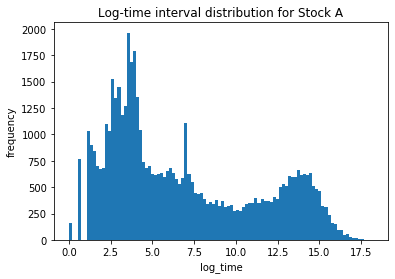

In [57]:
## Firstly we give the hist of the two set of time. The result is as following:
## Note that we take the log value of the intervals to hist.

P1=plt.hist(l_TIA,100)
plt.xlabel('log_time')  
plt.ylabel('frequency')  
plt.title(r'Log-time interval distribution for Stock A')  
plt.show()

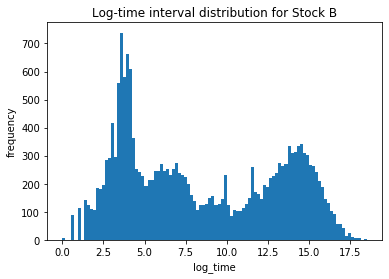

In [58]:
P1=plt.hist(l_TIB,100)
plt.xlabel('log_time')  
plt.ylabel('frequency')  
plt.title(r'Log-time interval distribution for Stock B') 
plt.show()

From the two plots, seems that the time intervals for each stocks approximately form ome certain Gaussian Mixture Distribution. Here we can use EM-Algorithm to calculate the parameters; 

In [59]:
from sklearn.mixture import GaussianMixture 

gmmA=GaussianMixture(n_components=2)
gmmB=GaussianMixture(n_components=2)
gmmA.fit(l_TIA.reshape(-1,1))
gmmB.fit(l_TIA.reshape(-1,1))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [60]:
## Calculating Parameters and save the results
weight_A=np.array([[gmmA.weights_[0],gmmA.weights_[1]]])
mu_A=np.array([[gmmA.means_[0][0],gmmA.means_[1][0]]])
var_A=np.array([[gmmA.covariances_[0][0][0],gmmA.covariances_[1][0][0]]])
weight_B=np.array([[gmmB.weights_[0],gmmB.weights_[1]]])
mu_B=np.array([[gmmB.means_[0][0],gmmA.means_[1][0]]])
var_B=np.array([[gmmB.covariances_[0][0][0],gmmB.covariances_[1][0][0]]])

## Now put the parameters in one datatable:
par_A=np.concatenate((weight_A,mu_A,var_A))
par_B=np.concatenate((weight_B,mu_B,var_B))
par_A.shape=(6,1)
par_B.shape=(6,1)
par_name=np.array([['weight_1'],['weight_2'],['mu_1'],['mu_2'],['sigma_1'],['sigma_2']])
Result=pd.DataFrame(np.hstack((par_name,par_A,par_B)))
Result.columns=['parameter_name','Stock A','Stock B']
Result

,parameter_name,Stock A,Stock B
0,weight_1,0.6695615539227742,0.6696273789112022
1,weight_2,0.33043844607726586,0.33037262108880977
2,mu_1,4.1073110699261735,4.107702105985726
3,mu_2,12.408720917645317,12.408720917645317
4,sigma_1,3.9898957769417565,3.9911812571283156
5,sigma_2,5.103018778443262,5.100062509076796


That is, let $TL_A$, $TL_B$ be the log time interval that the stock information change, then the distribution of $TL_A$ and $TL_B$ are as following:

$$f_{TL_A}(t)=0.67N(t|4.108,3.99)+0.33N(t|12.409,5.10)$$

$$f_{TL_B}(t)=0.67N(t|4.108,3.99)+0.33N(t|12.405,5.10)$$

The two distributions are approximately the same, which means that the interval of time change does not rely on the type of stocks.

Above all, the predicting procedure for one certain stock (A or B) can be expressed as this: 

(1) First of all, sample $X$ from the Gaussian Mixture Model $0.67N(4.108,3.99)+0.33N(12.409,5.10)$; then calculate the time interval $t=exp(X)$; use this time interval, find the certain time that the stock data changes.

(2) For the `bid` and `ask` responsors, using the models construct in part 1 to predict the new values based on the last three different conditions

(3) For `bidsz` and `asksz`, using the Poisson Regression model construct in part 2 to predict the new values based on the last three different conditions; after prediction, calculate the exponential values and find the nearest integers; the integers are the predicted `bidsz` and `asksz`.

In [61]:
## Part1: Time intervals for trading
TR_A=np.array(trade_A['time'])
TRI_A=list(filter(nonz,[TR_A[i+1]-TR_A[i] for i in range(len(TR_A)-1)]))
l_TRIA=np.log(TRI_A)
TR_B=np.array(trade_B['time'])
TRI_B=list(filter(nonz,[TR_B[i+1]-TR_B[i] for i in range(len(TR_B)-1)]))
l_TRIB=np.log(TRI_B)

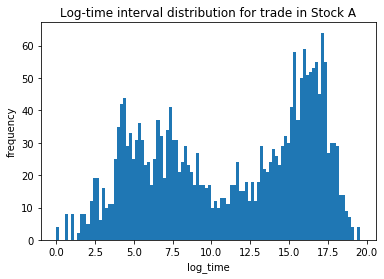

In [62]:
P1=plt.hist(l_TRIA,100)
plt.xlabel('log_time')  
plt.ylabel('frequency')  
plt.title(r'Log-time interval distribution for trade in Stock A')  
plt.show()

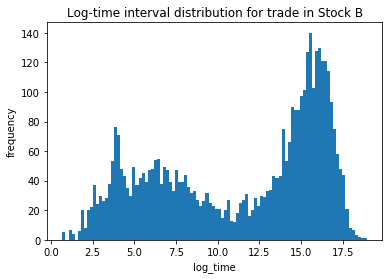

In [63]:
P2=plt.hist(l_TRIB,100)
plt.xlabel('log_time')  
plt.ylabel('frequency')  
plt.title(r'Log-time interval distribution for trade in Stock B')  
plt.show()

In [64]:
T_gmmA=GaussianMixture(n_components=2)
T_gmmB=GaussianMixture(n_components=2)
T_gmmA.fit(l_TRIA.reshape(-1,1))
T_gmmB.fit(l_TRIA.reshape(-1,1))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [65]:
## Calculating Parameters and save the results
Tweight_A=np.array([[T_gmmA.weights_[0],T_gmmA.weights_[1]]])
Tmu_A=np.array([[T_gmmA.means_[0][0],T_gmmA.means_[1][0]]])
Tvar_A=np.array([[T_gmmA.covariances_[0][0][0],T_gmmA.covariances_[1][0][0]]])
Tweight_B=np.array([[T_gmmB.weights_[0],T_gmmB.weights_[1]]])
Tmu_B=np.array([[T_gmmB.means_[0][0],T_gmmA.means_[1][0]]])
Tvar_B=np.array([[T_gmmB.covariances_[0][0][0],T_gmmB.covariances_[1][0][0]]])

## Now put the parameters in one datatable:
T_par_A=np.concatenate((Tweight_A,Tmu_A,Tvar_A))
T_par_B=np.concatenate((Tweight_B,Tmu_B,Tvar_B))
T_par_A.shape=(6,1)
T_par_B.shape=(6,1)
T_par_name=np.array([['weight_1'],['weight_2'],['mu_1'],['mu_2'],['sigma_1'],['sigma_2']])
T_Result=pd.DataFrame(np.hstack((T_par_name,T_par_A,T_par_B)))
T_Result.columns=['parameter_name','Stock A','Stock B']
T_Result

,parameter_name,Stock A,Stock B
0,weight_1,0.4993374046931897,0.5004850137263283
1,weight_2,0.5006625953068102,0.49951498627367125
2,mu_1,6.571660559464606,15.697190356721295
3,mu_2,15.695870061221468,15.695870061221468
4,sigma_1,7.318258223970258,3.1272338646351745
5,sigma_2,3.1314988002312885,7.326493954155003


In [66]:
## Part2: Prediction of trading result
# To begin with, setting the dataset, and stick the previous

In [67]:
FinT_A=pd.concat([ST_A,A1,A2,A3],axis=1)
FinT_B=pd.concat([ST_B,B1,B2,B3],axis=1)
TradeA=trade_A[['time','trdsz','trdsd','trdpx']].reset_index(drop=True)
#TradeA
TR_A=pd.merge(TradeA,FinT_A,how='inner',on='time')
TR_A=TR_A[['time','trdsz','trdsd','trdpx','bid1','bidsz1','ask1','asksz1',
                                          'bid2','bidsz2','ask2','asksz2',
                                          'bid3','bidsz3','ask3','asksz3']]
TR_A['time']=(TR_A['time']-min(TR_A['time']))/pow(10,6)
TR_Aask=TR_A[TR_A['trdsd']==1]
TR_Abid=TR_A[TR_A['trdsd']==-1]

TradeB=trade_B[['time','trdsz','trdsd','trdpx']].reset_index(drop=True)
#TradeB
TR_B=pd.merge(TradeB,FinT_B,how='inner',on='time')
TR_B=TR_B[['time','trdsz','trdsd','trdpx','bid1','bidsz1','ask1','asksz1',
                                          'bid2','bidsz2','ask2','asksz2',
                                          'bid3','bidsz3','ask3','asksz3']]
TR_B['time']=(TR_B['time']-min(TR_B['time']))/pow(10,6)
TR_Bask=TR_B[TR_B['trdsd']==1]
TR_Bbid=TR_B[TR_B['trdsd']==-1]

In [68]:
# First of all, separate all the datasets into training and testing parts, in portion 9:1
train_trAask=TR_Aask[0:int(0.9*len(TR_Aask))]
test_trAask=TR_Aask[int(0.9*len(TR_Aask)):len(TR_Aask)]
train_trAbid=TR_Abid[0:int(0.9*len(TR_Abid))]
test_trAbid=TR_Abid[int(0.9*len(TR_Abid)):len(TR_Abid)]
train_trBask=TR_Bask[0:int(0.9*len(TR_Bask))]
test_trBask=TR_Bask[int(0.9*len(TR_Bask)):len(TR_Bask)]
train_trBbid=TR_Bbid[0:int(0.9*len(TR_Bbid))]
test_trBbid=TR_Bbid[int(0.9*len(TR_Bbid)):len(TR_Bbid)]

l_trtrAask=TR_Abid[0:int(0.9*len(TR_Aask))]
l_trtrAask['trdsz']=np.log(l_trtrAask['trdsz'])
l_trtrAbid=TR_Abid[0:int(0.9*len(TR_Abid))]
l_trtrAbid['trdsz']=np.log(l_trtrAbid['trdsz'])
l_trtrBask=TR_Bbid[0:int(0.9*len(TR_Bask))]
l_trtrBask['trdsz']=np.log(l_trtrBask['trdsz'])
l_trtrBbid=TR_Bbid[0:int(0.9*len(TR_Bbid))]
l_trtrBbid['trdsz']=np.log(l_trtrBbid['trdsz'])

l_trteAask=TR_Abid[int(0.9*len(TR_Abid)):len(TR_Aask)]
l_trteAask['trdsz']=np.log(l_trteAask['trdsz'])
l_trteAbid=TR_Abid[int(0.9*len(TR_Abid)):len(TR_Abid)]
l_trteAbid['trdsz']=np.log(l_trteAbid['trdsz'])
l_trteBask=TR_Bbid[int(0.9*len(TR_Bask)):len(TR_Bask)]
l_trteBask['trdsz']=np.log(l_trteBask['trdsz'])
l_trteBbid=TR_Bbid[int(0.9*len(TR_Bbid)):len(TR_Bbid)]
l_trteBbid['trdsz']=np.log(l_trteBbid['trdsz'])

In [69]:
# For `trdpx`, here we will only use elastic net method to fit.
Alpha=np.logspace(-5,1,100)
elastic_trA_bid=linear_model.ElasticNet(l1_ratio=0.7)
elastic_trA_ask=linear_model.ElasticNet(l1_ratio=0.7)
elastic_trB_bid=linear_model.ElasticNet(l1_ratio=0.7)
elastic_trB_ask=linear_model.ElasticNet(l1_ratio=0.7)
trA_bid_train_errors=list()
trA_ask_train_errors=list()
trB_bid_train_errors=list()
trB_ask_train_errors=list()

for alpha in Alpha:
    elastic_trA_bid.set_params(alpha=alpha)
    elastic_trA_ask.set_params(alpha=alpha)
    elastic_trB_bid.set_params(alpha=alpha)
    elastic_trB_ask.set_params(alpha=alpha)    
    
    elastic_trA_bid.fit(train_trAbid[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_trAbid['trdpx'])
    elastic_trA_ask.fit(train_trAask[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_trAask['trdpx'])    
    elastic_trB_bid.fit(train_trBbid[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_trBbid['trdpx'])
    elastic_trB_ask.fit(train_trBask[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_trBask['trdpx'])        

    trA_bid_train_errors.append(elastic_trA_bid.score(test_trAbid[['time',
                           'bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                           'bid3','bidsz3','ask3','asksz3']],test_trAbid['trdpx']))
    trA_ask_train_errors.append(elastic_trA_bid.score(test_trAask[['time',
                           'bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                           'bid3','bidsz3','ask3','asksz3']],test_trAask['trdpx']))
    trB_bid_train_errors.append(elastic_trB_bid.score(test_trBbid[['time',
                           'bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                           'bid3','bidsz3','ask3','asksz3']],test_trBbid['trdpx']))
    trB_ask_train_errors.append(elastic_trB_bid.score(test_trBask[['time',
                           'bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                           'bid3','bidsz3','ask3','asksz3']],test_trBask['trdpx']))    

In [70]:
### The regression coefficients
elastic_trA_bid.set_params(alpha=Alpha[np.argmax(trA_bid_train_errors)])
coef_trA_bid=elastic_trA_bid.fit(train_trAbid[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_trAbid['trdpx']).coef_
intc_trA_bid=elastic_trA_bid.fit(train_trAbid[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_trAbid['trdpx']).intercept_
trA_bid_test_errors=elastic_trA_bid.score(test_trAbid[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],test_trAbid['trdpx'])

elastic_trA_ask.set_params(alpha=Alpha[np.argmax(trA_ask_train_errors)])
coef_trA_ask=elastic_trA_ask.fit(train_trAask[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_trAask['trdpx']).coef_
intc_trA_ask=elastic_trA_ask.fit(train_trAask[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_trAask['trdpx']).intercept_
trA_ask_test_errors=elastic_trA_ask.score(test_trAask[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],test_trAask['trdpx'])

elastic_trB_bid.set_params(alpha=Alpha[np.argmax(trB_bid_train_errors)])
coef_trB_bid=elastic_trB_bid.fit(train_trBbid[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_trBbid['trdpx']).coef_
intc_trB_bid=elastic_trB_bid.fit(train_trBbid[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_trBbid['trdpx']).intercept_
trB_bid_test_errors=elastic_trB_bid.score(test_trBbid[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],test_trBbid['trdpx'])

elastic_trB_ask.set_params(alpha=Alpha[np.argmax(trB_ask_train_errors)])
coef_trB_ask=elastic_trB_ask.fit(train_trBask[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_trBask['trdpx']).coef_
intc_trB_ask=elastic_trB_ask.fit(train_trBask[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_trBask['trdpx']).intercept_
trB_ask_test_errors=elastic_trB_ask.score(test_trBask[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],test_trBask['trdpx'])
## The performance upon each responsors
Score=[trA_bid_test_errors,trA_ask_test_errors,trB_bid_test_errors,trB_ask_test_errors]
Score

[0.9947686997736793, 0.9597860457989849, 0.9955058309239992, 0.991589550352823]

Here we output the parameters for each regression model

In [71]:
## For A-bid
predictor=['Intercept','time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']
Coef=np.hstack((np.array(intc_trA_bid),coef_trA_bid))
DT_trAbid=pd.DataFrame([predictor,Coef])
DT_trAbid

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Intercept,time,bid1,bidsz1,ask1,asksz1,bid2,bidsz2,ask2,asksz2,bid3,bidsz3,ask3,asksz3
1,44.3882,6.40475e-06,0.125062,-0,0.413018,-0.00252505,0.162735,-0,0.168692,-0,0.0672212,-6.87251e-05,0.0526478,-0


In [72]:
## For A-ask
predictor=['Intercept','time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']
Coef=np.hstack((np.array(intc_trA_ask),coef_trA_ask))
DT_trAask=pd.DataFrame([predictor,Coef])
DT_trAask

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Intercept,time,bid1,bidsz1,ask1,asksz1,bid2,bidsz2,ask2,asksz2,bid3,bidsz3,ask3,asksz3
1,6.64197,-6.88099e-07,0.715462,0.00704736,0.0958751,0.000406771,0.130506,-0.00300398,0,-0,0.0565363,-0.00291342,0,-0.000544843


In [73]:
## For B-bid
predictor=['Intercept','time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']
Coef=np.hstack((np.array(intc_trB_bid),coef_trB_bid))
DT_trBbid=pd.DataFrame([predictor,Coef])
DT_trBbid

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Intercept,time,bid1,bidsz1,ask1,asksz1,bid2,bidsz2,ask2,asksz2,bid3,bidsz3,ask3,asksz3
1,72.3535,4.30394e-06,0.0657165,-0,0.418212,-0,0.116181,-0,0.254018,-0,0.00212984,-0,0.135816,-0


In [74]:
## For A-bid
predictor=['Intercept','time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']
Coef=np.hstack((np.array(intc_trB_ask),coef_trB_ask))
DT_trBask=pd.DataFrame([predictor,Coef])
DT_trBask

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Intercept,time,bid1,bidsz1,ask1,asksz1,bid2,bidsz2,ask2,asksz2,bid3,bidsz3,ask3,asksz3
1,18.9674,4.75697e-06,1.00749,0.0284058,0.0438867,0.0027109,0.0114334,-0.00891906,-0.0375723,-0.00446299,-0.0270264,-0.00769909,-0.000303344,0.00125181


In [75]:
# For `trdsz`, here we will only use Poisson Regression to fit. 
# Here for B-ask we will only use the previous two recordsto fit, because 
# singular matrix will be produced, and the fit will fail.
poisson = GeneralizedPoisson.from_formula

## Now begin our regression. 
poi_trAbid=poisson('trdsz~time+bid1+bidsz1+asksz1+\
                             bid2+bidsz2+ask2+asksz2+\
                             bid3+ask3+asksz3',l_trtrAbid).fit_regularized()
poi_trAask=poisson('trdsz~time+bid1+ask1+asksz1+\
                             bidsz2+ask2+asksz2+\
                             bid3+bidsz3+ask3+asksz3',l_trtrAask).fit_regularized()
poi_trBbid=poisson('trdsz~time+bid1+bidsz1+ask1+asksz1+\
                             bid2+bidsz2+ask2+asksz2+\
                             bid3+bidsz3+ask3+asksz3',l_trtrBbid).fit_regularized()
poi_trBask=poisson('trdsz~time+bidsz1+ask1+asksz1+\
                             bid2+bidsz2+ask2+asksz2',l_trtrBask).fit_regularized()


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8176591713458253
            Iterations: 45
            Function evaluations: 69
            Gradient evaluations: 45
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8576015096137417
            Iterations: 30
            Function evaluations: 57
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4966675923901774
            Iterations: 18
            Function evaluations: 37
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.44279147062173874
            Iterations: 31
            Function evaluations: 51
            Gradient evaluations: 31


In [76]:
## Calculating the MSEs
pred_A_bidsz=np.array(poi_trAbid.predict(l_trteAbid))
pred_A_asksz=np.array(poi_trAask.predict(l_trteAask))
pred_B_bidsz=np.array(poi_trBbid.predict(l_trteBbid))
pred_B_asksz=np.array(poi_trBask.predict(l_trteBask))

T_Abidsz=np.array(l_trteAbid['trdsz'])
T_Aasksz=np.array(l_trteAask['trdsz'])
T_Bbidsz=np.array(l_trteBbid['trdsz'])
T_Basksz=np.array(l_trteBask['trdsz'])

MSE_Abidsz=np.sqrt(np.mean((pred_A_bidsz-T_Abidsz)**2))
MSE_Aasksz=np.sqrt(np.mean((pred_A_asksz-T_Aasksz)**2))
MSE_Bbidsz=np.sqrt(np.mean((pred_B_bidsz-T_Bbidsz)**2))
MSE_Basksz=np.sqrt(np.mean((pred_B_asksz-T_Basksz)**2))

MSE=[MSE_Abidsz,MSE_Aasksz,MSE_Bbidsz,MSE_Basksz]
MSE

[0.9854398794956292,
 0.9195362801871008,
 1.6590687471193675,
 0.8713803838365993]

In [77]:
## Here are the fitting result of the Poisson Regressions

In [78]:
poi_trAbid.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                  trdsz   No. Observations:                 7625
Model:             GeneralizedPoisson   Df Residuals:                     7613
Method:                           MLE   Df Model:                           11
Date:                Fri, 27 Dec 2019   Pseudo R-squ.:                 0.04528
Time:                        22:37:03   Log-Likelihood:                -6234.7
converged:                       True   LL-Null:                       -6530.3
Covariance Type:            nonrobust   LLR p-value:                9.713e-120
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    135.5633     15.686      8.642      0.000     104.819     166.307
time        2.022e-05   4.01e-06      5.040      0.000    1.24e-05    2.81e-05
bid1           0.7637      0.188      4.053      0.000       0.394       1.133
bidsz1        -0.0024      0.005     -0.521      0.603      -0.011       0.007
asksz1         0.0060      0.001      4.303      0.000       0.003       0.009
bid2           0.0702      0.140      0.501      0.616      -0.204       0.344
bidsz2        -0.0047      0.005     -1.052      0.293      -0.014       0.004
ask2          -0.5778      0.144     -4.020      0.000      -0.860      -0.296
asksz2         0.0026      0.002      1.532      0.125      -0.001       0.006
bid3          -0.2474      0.081     -3.049      0.002      -0.406      -0.088
ask3          -0.0413      0.085     -0.484      0.628      -0.209       0.126
asksz3         0.0042      0.001      3.170      0.002       0.002       0.007
alpha         -0.0367      0.007     -4.951      0.000      -0.051      -0.022
==============================================================================
"""

In [79]:
poi_trAask.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                  trdsz   No. Observations:                 8473
Model:             GeneralizedPoisson   Df Residuals:                     8461
Method:                           MLE   Df Model:                           11
Date:                Fri, 27 Dec 2019   Pseudo R-squ.:                 0.03129
Time:                        22:37:21   Log-Likelihood:                -7266.5
converged:                       True   LL-Null:                       -7501.1
Covariance Type:            nonrobust   LLR p-value:                 1.075e-93
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    192.2186     15.312     12.554      0.000     162.208     222.229
time        2.529e-05    3.6e-06      7.030      0.000    1.82e-05    3.23e-05
bid1           0.8298      0.161      5.144      0.000       0.514       1.146
ask1           0.2673      0.211      1.268      0.205      -0.146       0.680
asksz1         0.0023      0.001      1.699      0.089      -0.000       0.005
bidsz2        -0.0046      0.004     -1.291      0.197      -0.012       0.002
ask2          -0.7984      0.277     -2.883      0.004      -1.341      -0.256
asksz2         0.0029      0.002      1.925      0.054   -5.22e-05       0.006
bid3          -0.2565      0.084     -3.045      0.002      -0.422      -0.091
bidsz3         0.0020      0.004      0.559      0.576      -0.005       0.009
ask3          -0.0887      0.145     -0.612      0.540      -0.373       0.195
asksz3         0.0065      0.001      6.334      0.000       0.004       0.008
alpha         -0.0235      0.008     -3.077      0.002      -0.038      -0.009
==============================================================================
"""

In [80]:
poi_trBbid.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                  trdsz   No. Observations:                 3178
Model:             GeneralizedPoisson   Df Residuals:                     3164
Method:                           MLE   Df Model:                           13
Date:                Fri, 27 Dec 2019   Pseudo R-squ.:                     nan
Time:                        22:37:29   Log-Likelihood:                -1578.4
converged:                       True   LL-Null:                           nan
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -115.2617     51.360     -2.244      0.025    -215.925     -14.599
time       -2.305e-05   1.24e-05     -1.857      0.063   -4.74e-05    1.27e-06
bid1          -0.0495      0.237     -0.208      0.835      -0.515       0.416
bidsz1        -0.0236      0.022     -1.077      0.281      -0.066       0.019
ask1          -0.1263      0.210     -0.602      0.547      -0.537       0.285
asksz1        -0.0287      0.012     -2.403      0.016      -0.052      -0.005
bid2          -0.0025      0.304     -0.008      0.993      -0.598       0.593
bidsz2         0.0270      0.028      0.962      0.336      -0.028       0.082
ask2          -0.0243      0.259     -0.094      0.925      -0.531       0.483
asksz2         0.0136      0.016      0.873      0.383      -0.017       0.044
bid3           0.2324      0.219      1.064      0.288      -0.196       0.661
bidsz3         0.0218      0.020      1.103      0.270      -0.017       0.061
ask3          -0.0175      0.183     -0.095      0.924      -0.377       0.342
asksz3         0.0628      0.011      5.602      0.000       0.041       0.085
alpha         -0.0003      0.013     -0.022      0.983      -0.025       0.025
==============================================================================
"""

In [81]:
poi_trBask.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                  trdsz   No. Observations:                 2079
Model:             GeneralizedPoisson   Df Residuals:                     2070
Method:                           MLE   Df Model:                            8
Date:                Fri, 27 Dec 2019   Pseudo R-squ.:                     nan
Time:                        22:37:35   Log-Likelihood:                -920.56
converged:                       True   LL-Null:                           nan
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -223.2759     64.852     -3.443      0.001    -350.384     -96.168
time        -6.56e-05   1.99e-05     -3.300      0.001      -0.000   -2.66e-05
bidsz1        -0.0143      0.030     -0.478      0.633      -0.073       0.044
ask1           0.1745      0.271      0.644      0.519      -0.356       0.705
asksz1        -0.0579      0.023     -2.545      0.011      -0.102      -0.013
bid2           0.2082      0.094      2.211      0.027       0.024       0.393
bidsz2         0.0163      0.029      0.559      0.576      -0.041       0.073
ask2          -0.3583      0.267     -1.342      0.180      -0.882       0.165
asksz2         0.1433      0.024      6.022      0.000       0.097       0.190
alpha         -0.0130      0.013     -1.037      0.300      -0.038       0.012
==============================================================================
"""

In [82]:
## Final part: Correlation of the change between Stock A and Stock B


In [83]:
Pri_A=Stock[['time','symbol','bid','ask']]
Pri_B=Stock[['time','symbol','bid','ask']]
Time=Stock['time']

## Managing Stock A
Pri_A[Pri_A['symbol']=='STOCKB']=np.nan
Pri_A['time']=Time
Pri_A=Pri_A.fillna(method='bfill')

## Managing Stock B
Pri_B[Pri_B['symbol']=='STOCKA']=np.nan
Pri_B['time']=Time
Pri_B=Pri_B.fillna(method='bfill')

## Now calculating the correlation efficient

Cor_bid=np.corrcoef(Pri_A['bid'][1:-1],Pri_B['bid'][1:-1])
Cor_ask=np.corrcoef(Pri_A['ask'][1:-1],Pri_B['ask'][1:-1])
VCor=np.array([Cor_bid[1][0],Cor_ask[1][0]])
pricetag=np.array(['bid price','ask price'])

Res_Cor=pd.DataFrame([pricetag,VCor])
Res_Cor

,0,1
0,bid price,ask price
1,0.0209759,0.0208099


In [91]:
## Trade Prediction plot
time_Abid=TR_Abid['time']
Fit_Abid=elastic_trA_bid.fit(train_trAbid[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_trAbid['trdpx'])
Pred_trAbid=Fit_Abid.predict(TR_Abid[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']])

time_Aask=TR_Aask['time']
Fit_Aask=elastic_trA_ask.fit(train_trAask[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_trAask['trdpx'])
Pred_trAask=Fit_Aask.predict(TR_Aask[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']])

time_Bbid=TR_Bbid['time']
Fit_Bbid=elastic_trB_bid.fit(train_trBbid[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_trBbid['trdpx'])
Pred_trBbid=Fit_Bbid.predict(TR_Bbid[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']])

time_Bask=TR_Bask['time']
Fit_Bask=elastic_trB_ask.fit(train_trBask[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']],train_trBask['trdpx'])
Pred_trBask=Fit_Bask.predict(TR_Bask[['time','bid1','bidsz1','ask1','asksz1',
                           'bid2','bidsz2','ask2','asksz2',
                          'bid3','bidsz3','ask3','asksz3']])

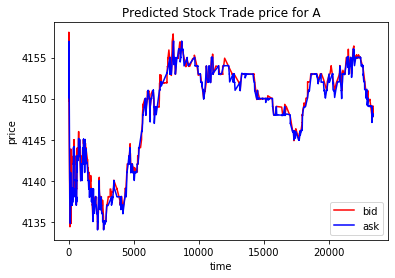

In [102]:
plt.xlabel('time')
plt.ylabel('price')
plt.title('Predicted Stock Trade price for A')
plt.plot(time_Abid,Pred_trAbid,'r-',label='bid')
plt.plot(time_Aask,Pred_trAask,'b-',label='ask')
plt.legend()

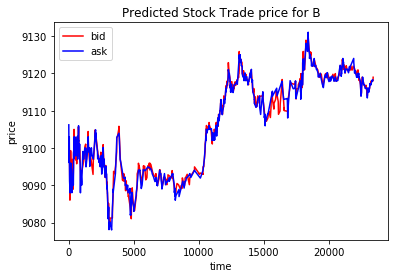

In [104]:
plt.xlabel('time')
plt.ylabel('price')
plt.title('Predicted Stock Trade price for B')
plt.plot(time_Bbid,Pred_trBbid,'r-',label='bid')
plt.plot(time_Bask,Pred_trBask,'b-',label='ask')
plt.legend()